In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import keras
from keras import backend
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3, ResNet152V2, VGG16

#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import time
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [5]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [6]:
def add_cnn_layers(base_model, model):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

In [7]:
def train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val):
    train_loss, train_accuracy, train_mse, train_mape, train_rmse = model.evaluate(x_train_normalized, y_train, verbose=1)
    val_loss, val_accuracy, val_mse, val_mape, val_rmse = model.evaluate(x_val_normalized, y_val, verbose=1)
    
    #Accuracy
    print("Training Accuracy:",train_accuracy*100,"%","")
    print("Validation Accuracy:",val_accuracy*100,"%","")

    #Loss
    print("\nTraining Loss:",train_loss)
    print("Validation Loss:",val_loss)

    #RMSE
    print("\nTraining RMSE:",train_rmse)
    print("Validation RMSE:",val_rmse)

    #MSE
    print("\nTraining MSE:",train_mse)
    print("Validation MSE:",val_mse)

    #MAPE
    print("\nTraining MAPE:",train_mape)
    print("Validation MAPE:",val_mape)

In [8]:
def test_accuracy(model, x_test_normalized, y_test):
    test_loss, test_accuracy, test_mse, test_mape, test_rmse = model.evaluate(x_test_normalized, y_test, verbose=1)

    print("\nTest Set Accuracy: ", test_accuracy*100,"%", 
          "\nTest Set Loss:", test_loss,
          "\nTest Set RMSE:", test_rmse,
          "\nTest Set MSE:", test_mse,
          "\nTest Set MAPE:", test_mape)

In [9]:
def plot_model_history(model_history, name):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    #Summarize history for accuracy
    axs[0,0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0,0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0,0].set_title('Model Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    axs[0,1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[0,1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[0,1].set_title('Model Loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[0,1].legend(['train', 'validation'], loc='best')
    
    #Summarize history for RMSE
    axs[1,0].plot(range(1,len(model_history.history['rmse'])+1),model_history.history['rmse'])
    axs[1,0].plot(range(1,len(model_history.history['val_rmse'])+1),model_history.history['val_rmse'])
    axs[1,0].set_title('Model RMSE')
    axs[1,0].set_ylabel('RMSE')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_xticks(np.arange(1,len(model_history.history['rmse'])+1),len(model_history.history['rmse'])/10)
    axs[1,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for MSE
    axs[1,1].plot(range(1,len(model_history.history['mse'])+1),model_history.history['mse'])
    axs[1,1].plot(range(1,len(model_history.history['val_mse'])+1),model_history.history['val_mse'])
    axs[1,1].set_title('Model MSE')
    axs[1,1].set_ylabel('MSE')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_xticks(np.arange(1,len(model_history.history['mse'])+1),len(model_history.history['mse'])/10)
    axs[1,1].legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('../Photos/' + name + '_model_history.png', dpi=300)

In [10]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predict the values from the testing set
    y_predict = model.predict(x_test_normalized)

    #Convert prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis = 1) 

    #Convert testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis = 1) 
    
    return y_predict_classes, y_true_classes

In [11]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [12]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('../Photos/' + name + '_confusion_matrix.png', dpi=300)

In [13]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    #Generate report
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

In [14]:
def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):

    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        
    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Calculation confusion matrix prediction error
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1))* 100

    #Bar plot
    plt.bar(np.arange(7), cm_prediction_error)

    #Plot title and labels
    plt.title(name)
    plt.xlabel('True Labels')
    plt.ylabel('Classified Labels %')
    
    #Save figure
    fig = plt
    fig.savefig('../Photos/' + name + '_label_classification_accuracy.png', dpi=300)

In [15]:
base_skin_dir = os.path.join('..', 'data')

In [16]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [17]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [20]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, '../data/HAM10000_metadata.csv'))

In [21]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get) #Image Local Path
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) #Full 'dx' name
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes #Unique code for each 'dx'

In [22]:
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [23]:
skin_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [24]:
skin_df.describe()

,age,cell_type_idx
count,9958.000000,10015.000000
mean,51.863828,3.623964
std,16.968614,1.208859
min,0.000000,0.000000
25%,40.000000,4.000000
50%,50.000000,4.000000
75%,65.000000,4.000000
max,85.000000,6.000000


In [25]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


In [26]:
skin_df = skin_df.drop_duplicates(subset='lesion_id')
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,../data/HAM10000_images_part_1/ISIC_0025837.jpg,Benign keratosis-like lesions,2
...,...,...,...,...,...,...,...,...,...,...
9994,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face,../data/HAM10000_images_part_2/ISIC_0030877.jpg,Actinic keratoses,0
10001,HAM_0000020,ISIC_0031922,akiec,histo,60.0,female,face,../data/HAM10000_images_part_2/ISIC_0031922.jpg,Actinic keratoses,0
10004,HAM_0005579,ISIC_0029309,akiec,histo,80.0,male,face,../data/HAM10000_images_part_2/ISIC_0029309.jpg,Actinic keratoses,0
10008,HAM_0001576,ISIC_0033705,akiec,histo,60.0,male,face,../data/HAM10000_images_part_2/ISIC_0033705.jpg,Actinic keratoses,0


In [27]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              52
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [28]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [29]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='cell_type'>

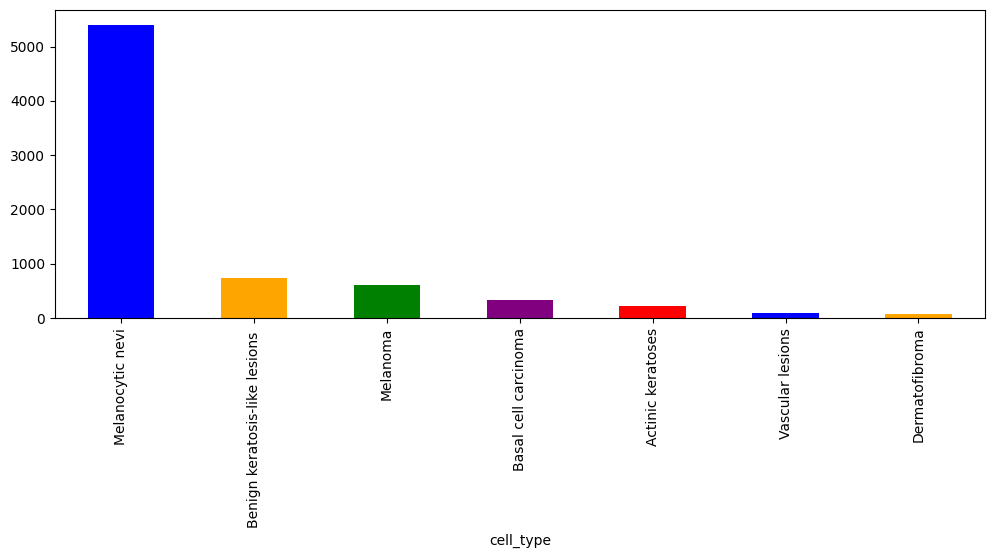

In [30]:
plt.figure(figsize=(12, 4))
skin_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red"])

In [31]:
skin_df['cell_type'].value_counts()
skin_df['dx'].value_counts()

cell_type
Melanocytic nevi                  5403
Benign keratosis-like lesions      727
Melanoma                           614
Basal cell carcinoma               327
Actinic keratoses                  228
Vascular lesions                    98
Dermatofibroma                      73
Name: count, dtype: int64

dx
nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: count, dtype: int64

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='dx_type'>

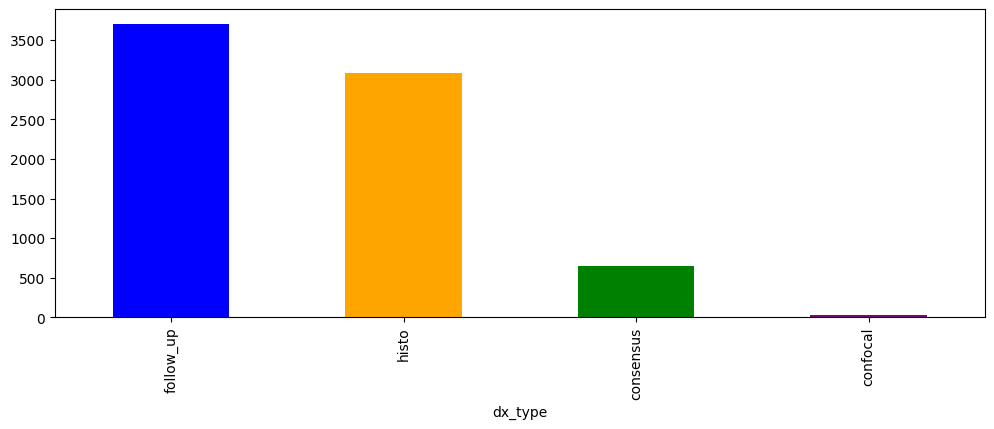

In [32]:
plt.figure(figsize=(12, 4))
skin_df['dx_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple"])

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='localization'>

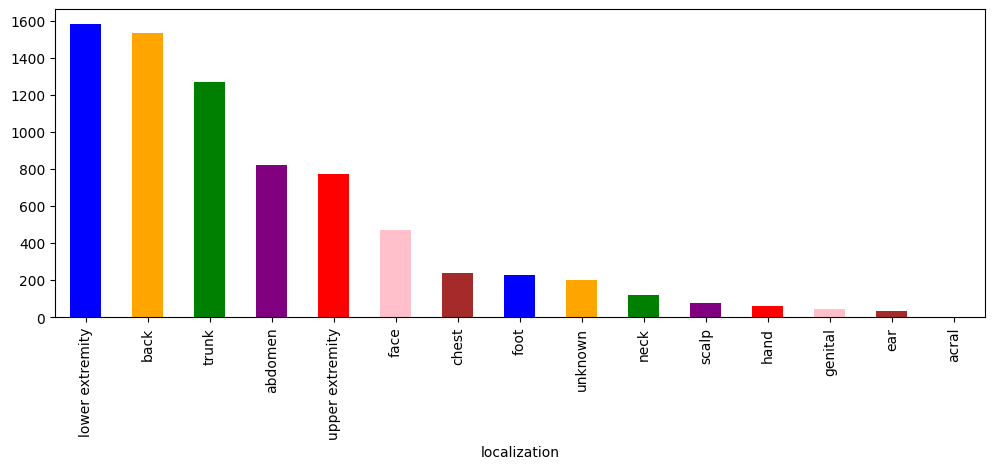

In [33]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red", "pink", "brown"])

<Axes: >

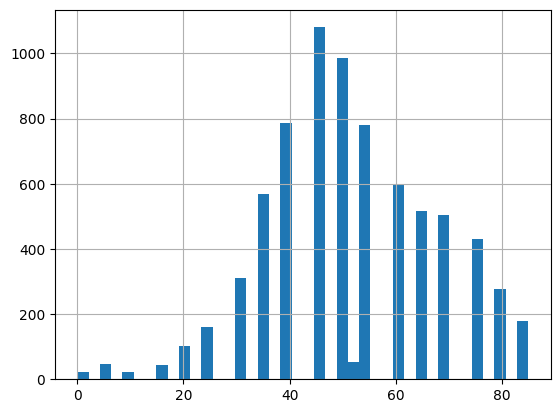

In [34]:
skin_df['age'].hist(bins=40)

<Figure size 1200x400 with 0 Axes>

<Axes: xlabel='sex'>

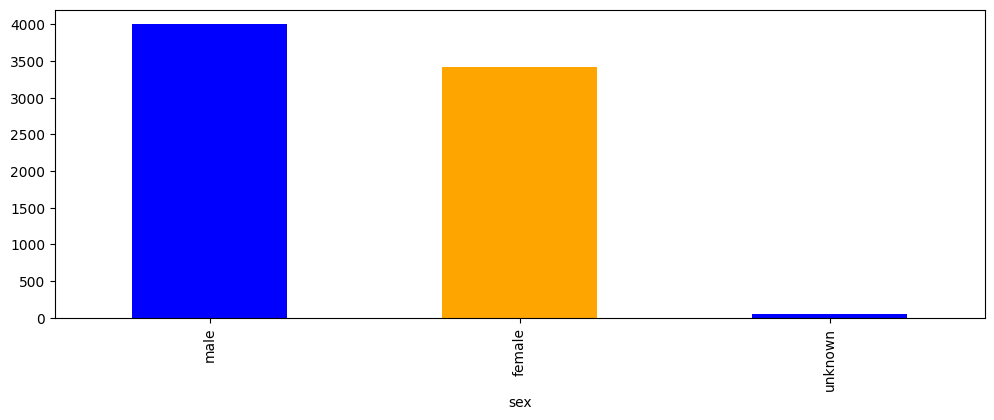

In [35]:
plt.figure(figsize=(12, 4))
skin_df['sex'].value_counts().plot(kind='bar', color=["blue", "orange"])

In [36]:
im = Image.open(skin_df["path"][0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [37]:
width/= 4
height/= 4
print("Width: ", width)
print("Height:", height)

Width:  150.0
Height: 112.5


In [38]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

In [39]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,"[[[188, 151, 193], [193, 156, 198], [192, 155,..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../data/HAM10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,"[[[186, 126, 135], [189, 131, 142], [192, 136,..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../data/HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,"[[[129, 87, 109], [139, 94, 117], [148, 102, 1..."
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face,../data/HAM10000_images_part_1/ISIC_0029176.jpg,Benign keratosis-like lesions,2,"[[[190, 144, 125], [191, 145, 129], [193, 146,..."
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back,../data/HAM10000_images_part_1/ISIC_0025837.jpg,Benign keratosis-like lesions,2,"[[[95, 61, 61], [105, 71, 71], [114, 77, 77], ..."


In [40]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(112, 150, 3)    7470
Name: count, dtype: int64

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

FileNotFoundError: [Errno 2] No such file or directory: '../Photos/category_samples.png'

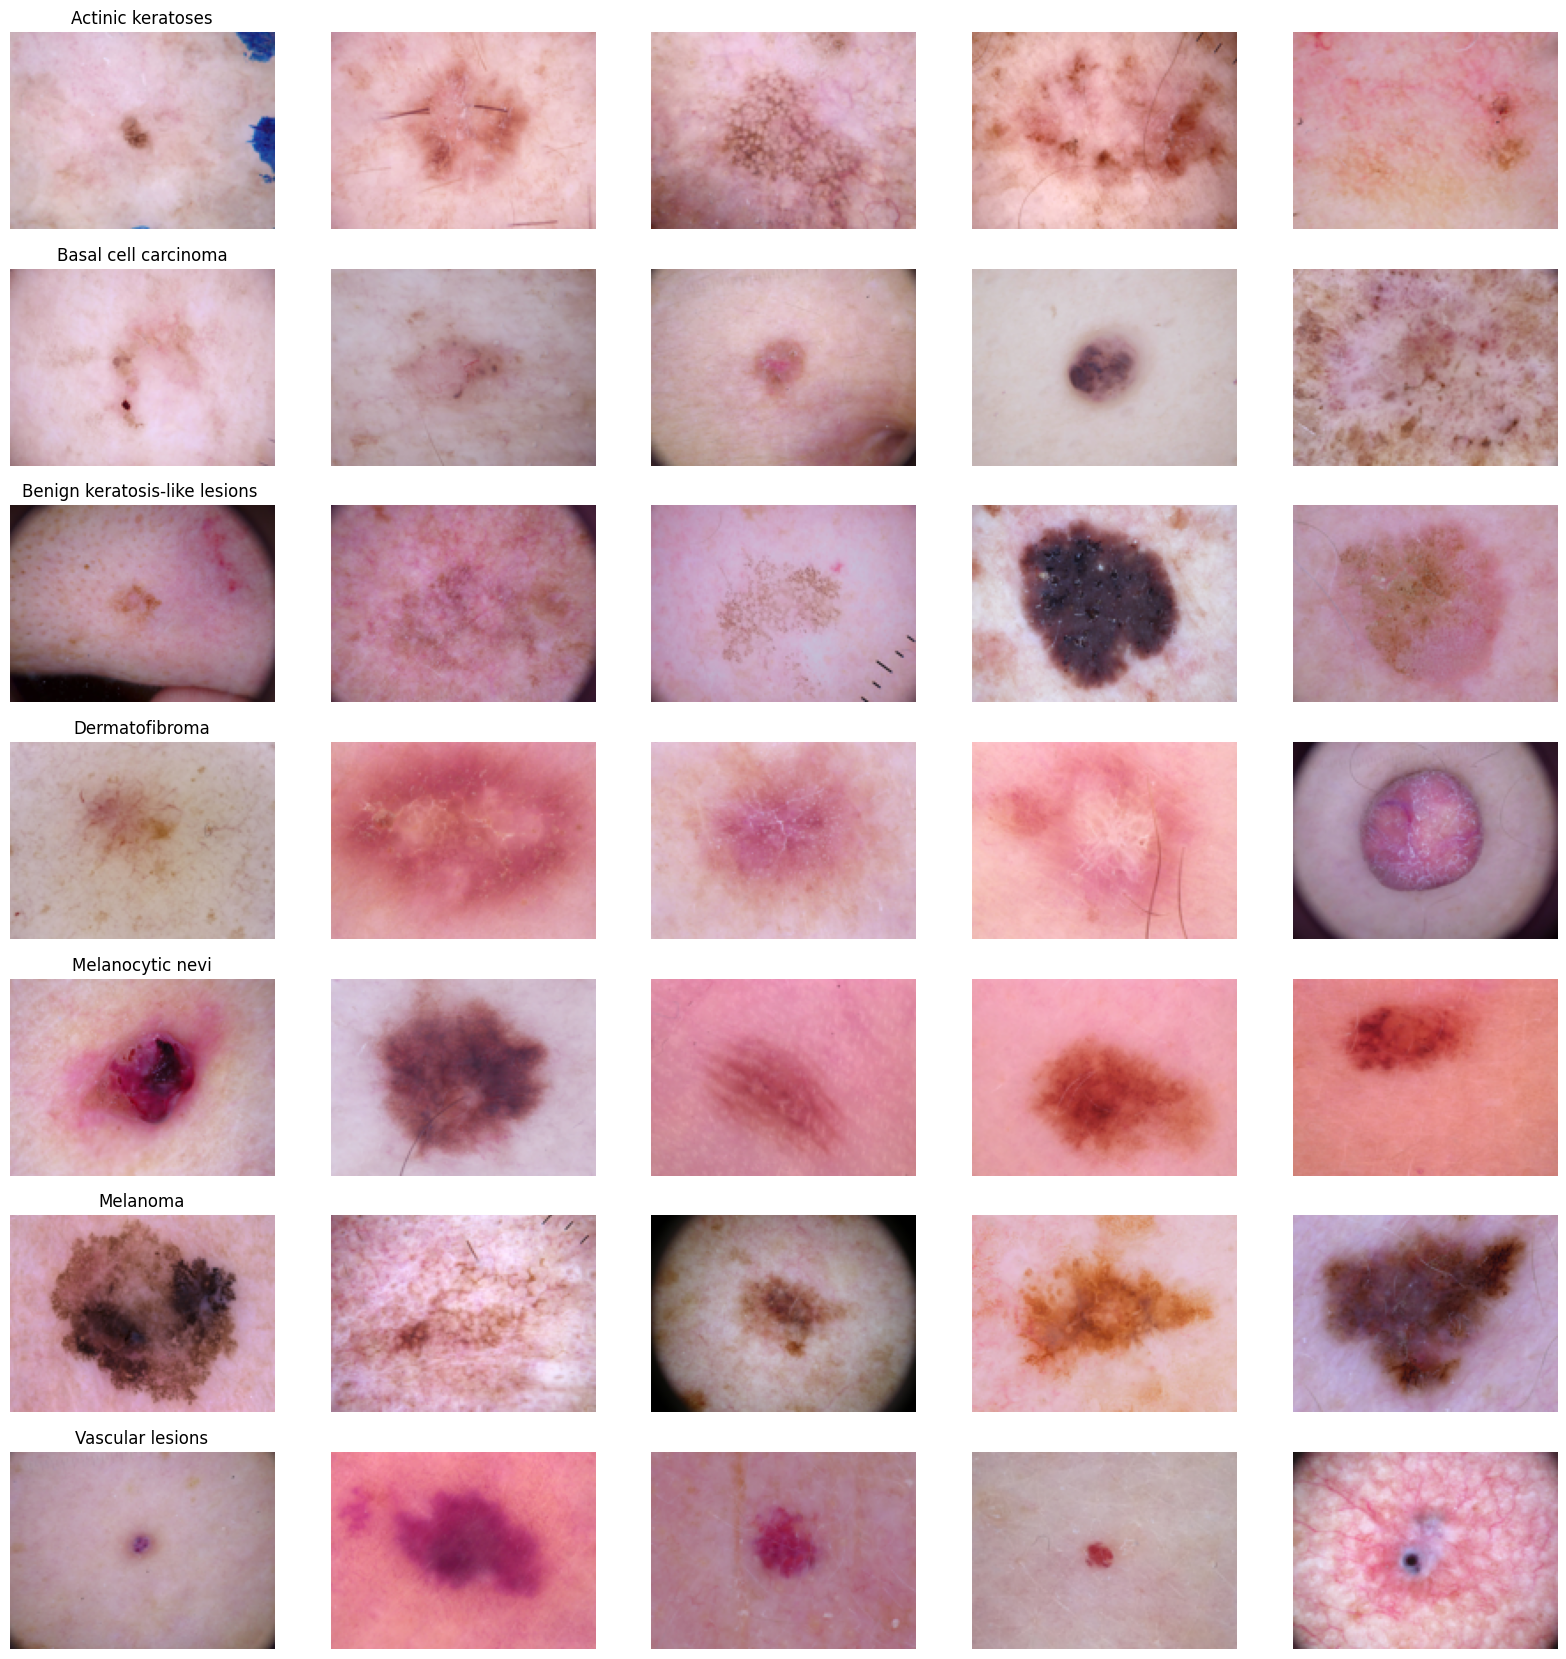

In [41]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('../Photos/category_samples.png', dpi=300)

In [42]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [43]:
num_classes = 7
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


We first split the dataset to 80% training data and 20% testing data. We then take the 80% training data and split it into 87.5% training data and 12.5% validation data, to form our 70% Training - 10% Validation - 20% Testing. Note that the split will be applied across each class individually to ensure there is enough samples from each class in each split for accurate modeling, meaning each class will be split 70:10:20 as well. This is done by setting 'stratify' in train_test_split function to our target.

Training: 80% * 87.5% = 70%
Validation: 80% * 12.5% = 10%
Testing: 20%

The hold-out method was prefered over the K-fold method here. K-fold cross-validation is often used for simple models with few parameters, models with simple hyperparameters and that are easy to optimize. Typical examples are linear regression, logistic regression, small neural networks and support vector machines. For a convolutional neural network with many parameters (e.g. more than one million) we just have too many possible changes in the architecture. In addition, lets look at a very important concept in machine learning; variance error vs. biased error. Let us say you have N models that you trained, they all have variance error and zero biased error, in this case using cross validation to select a model is not useful, but averaging the models is useful. If you have N models that all have different biased errors (non zero), then using cross validation is useful to select the best model, but averaging is harmful. Anytime you have models that have different biased errors, use cross validation to determine the best model. Anytime you have models that have variance errors, use averaging to determine the final outcome. CNN has tendency toward overfitting not underfitting. Today we know that the deeper the network the better it is, but overfitting is what scares us. Example: Alex-Hinton paper in 2012 (http://www.cs.toronto.edu/~hinton/absps/imagenet.pdf), the paper where Alex proposed his AlexNet network. You will see that most of the tricks they proposed is to deal with overfitting (variance error) and not biased errors.
80:20 Train Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

In [46]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

In [47]:
x_train_mean = np.mean(x_train_images)
x_train_std = np.std(x_train_images)

In [48]:
x_train_normalized = (x_train_images - x_train_mean)/x_train_std
x_val_normalized = (x_val_images - x_train_mean)/x_train_std
x_test_normalized = (x_test_images - x_train_mean)/x_train_std

In [49]:
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))

In [50]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last', 
                                    validation_split=0.0, 
                                    interpolation_order=1, 
                                    dtype='float32')

In [51]:
augmented_data.fit(x_train_normalized)

In [52]:
#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 112, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 112, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 56, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 56, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 56, 64)        36928     
                                                        

In [53]:
import tensorflow.keras.optimizers as tko
optimizer = tko.Adam(lr=0.001)

In [54]:
loss = "categorical_crossentropy"

In [55]:
metrics=["accuracy", 'mse', 'mape', rmse]

In [56]:
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [57]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [58]:
skin_df.loc[skin_df['dx'] == 'akiec', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bcc', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'bkl', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'df', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'nv', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'mel', ['cell_type', 'cell_type_idx']].head(1)
skin_df.loc[skin_df['dx'] == 'vasc', ['cell_type', 'cell_type_idx']].head(1)

,cell_type,cell_type_idx
9687,Actinic keratoses,0


,cell_type,cell_type_idx
2462,Basal cell carcinoma,1


,cell_type,cell_type_idx
0,Benign keratosis-like lesions,2


,cell_type,cell_type_idx
1095,Dermatofibroma,3


,cell_type,cell_type_idx
64,Melanocytic nevi,4


,cell_type,cell_type_idx
1211,Melanoma,5


,cell_type,cell_type_idx
2320,Vascular lesions,6


In [59]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # nv # Try to make the model more sensitive to Melanocytic nevi
    5: 1.0, # mel
    6: 1.0, # vasc
}

In [60]:
epochs = 50
batch_size = 10
steps_per_epoch = len(x_train_normalized) / 10

In [61]:
# time_callback = TimeHistory()
# csv_logger = CSVLogger('../logs/original_cnn_training.log', separator=',', append=False)
# history = model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
#                               epochs = epochs, 
#                               verbose = 1,
#                               class_weight = class_weights,
#                               validation_data = (x_val_normalized, y_val), 
#                               steps_per_epoch = steps_per_epoch,
#                               callbacks = [reduce_lr, time_callback, csv_logger])

/var/folders/50/f9j307152c96gfl9f3nhphqw0000gn/T/ipykernel_42813/4157185857.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),


Epoch 1/50
478/478 [==============================] - ETA: 0s - loss: 1.2195 - accuracy: 0.7211 - mse: 0.0613 - mape: 48593776.0000 - rmse: 0.1603

NotFoundError: ../logs/original_cnn_training.log; No such file or directory

In [63]:
print("\nTotal Time:",sum(time_callback.times),"s\n")


Total Time: 96.30130505561829 s



In [64]:
model.save('../Models/original_cnn_model.h5.h5')
print("Saved entire model file to disk")

Saved entire model file to disk


/Users/s1suu/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [65]:
# serialize model to JSON
model_json = model.to_json()
with open('../Models/original_cnn_model.h5.json', "w") as json_file:
    json_file.write(model_json)
print("Saved model's architecture to disk")

# serialize weights to HDF5
model.save_weights('../Models/original_cnn_model.h5.h5')
print("Saved model's weights to disk")

6353

Saved model's architecture to disk
Saved model's weights to disk


In [66]:
loading_dependencies = {
     'rmse': rmse
}

In [67]:
model = load_model('../Models/original_cnn_model.h5.h5', custom_objects=loading_dependencies)
print("Loaded entire model file from disk")

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x2a58dbee0>.

In [68]:
model_log_data = pd.read_csv('../Models/original_cnn_model.h5.h5', sep=',', engine='python')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte

In [69]:
model_name = "BasicCNN"

In [70]:
train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val)

38/38 [==============================] - 4s 104ms/step - loss: 0.8599 - accuracy: 0.7224 - mse: 0.0566 - mape: 43667080.0000 - rmse: 0.1446
Training Accuracy: 72.36401438713074 % 
Validation Accuracy: 72.24080562591553 % 

Training Loss: 0.84266197681427
Validation Loss: 0.8599432110786438

Training RMSE: 0.14497464895248413
Validation RMSE: 0.14463959634304047

Training MSE: 0.0562356598675251
Validation MSE: 0.0566474124789238

Training MAPE: 43866244.0
Validation MAPE: 43667080.0


In [72]:
test_accuracy(model, x_test_normalized, y_test)

47/47 [==============================] - 5s 101ms/step - loss: 0.8776 - accuracy: 0.7229 - mse: 0.0580 - mape: 44667768.0000 - rmse: 0.1483

Test Set Accuracy:  72.28915691375732 % 
Test Set Loss: 0.877646803855896 
Test Set RMSE: 0.14830754697322845 
Test Set MSE: 0.05797823145985603 
Test Set MAPE: 44667768.0
